# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.25,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_6_drop0.25e500b512_custom/lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xdist_uniform_noise_normal_0.25
lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.25


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.3min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,-0.142,-0.402,-0.741,0.255,0.968,-0.320,4.227,-8.982,4.891,-0.249,0.968,-0.320,4.227,-8.982,4.891,-0.249,-0.009,-0.227,0.382,0.317,0.171,0.105,0.392,-0.297,0.304,0.049,0.501,-0.088,-0.019,0.413,0.092,0.474,-0.040,0.204,0.267,0.231,-0.056,0.044,0.008,-0.042,-0.404,-0.090,0.292,-0.291,-0.209,-0.233,0.000,0.000,-0.176,-0.165,0.231,0.232,-0.204,0.000,-0.164,0.307,-0.213,0.000,0.000,-0.200,0.242,-0.197,0.230,0.252,0.223,0.240,0.291,-0.045,-0.023,0.000,0.000,0.000,-0.165,0.000,0.000,0.000,-0.254,-0.359,-0.491,-0.569,0.344,0.404,-0.370,-0.408,-0.644,0.129,-0.316,-0.352,-0.364,-0.354,0.346,-0.395,0.696,0.218,0.351,0.246,0.347,-0.311,-0.044,-0.261,-0.383,-0.059,-0.800,0.144,-0.258,-0.315,0.199
4684,1373158606,-0.794,0.241,-0.127,-0.188,-0.535,-0.939,-0.443,-1.076,-0.324,1.181,-1.350,0.529,-0.443,-1.076,-0.324,1.181,-1.350,0.529,-0.009,-0.227,0.380,0.275,0.155,0.091,0.341,-0.297,0.242,0.419,0.507,-0.088,-0.019,0.386,0.090,0.490,0.008,0.214,0.239,0.224,0.033,0.189,0.141,-0.042,-0.404,-0.090,0.201,-0.291,-0.209,-0.233,0.000,0.000,0.096,0.097,-0.074,-0.073,0.101,0.000,0.096,0.117,0.099,0.000,0.000,0.100,-0.071,0.097,-0.023,-0.066,-0.077,-0.072,-0.040,0.096,0.109,0.000,0.000,0.000,0.096,0.000,0.000,0.000,-0.254,-0.359,-0.397,-0.393,0.149,0.188,-0.238,-0.408,-0.418,-0.127,-0.262,-0.352,-0.364,-0.255,0.122,-0.339,0.394,0.026,0.183,0.066,0.049,-0.459,-0.187,-0.261,-0.383,-0.059,-0.486,0.144,-0.258,-0.315,-0.091
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.083,-0.566,-1.312,9.855,-17.445,21.081,-9.413,-0.566,-1.312,9.855,-17.445,21.081,-9.413,-0.009,-0.227,0.119,0.084,0.683,0.595,0.120,-0.297,0.066,0.930,0.333,-0.088,-0.019,0.382,0.612,0.083,0.469,0.826,0.793,0.817,0.591,0.038,0.005,-0.042,-0.404,-0.090,0.045,-0.291,-0.209,-0.233,0.000,0.000,-0.125,-0.093,-0.262,-0.335,-0.120,0.000,-0.079,-0.191,-0.016,0.000,0.000,-0.225,-0.343,0.459,-0.275,-0.160,-0.154,-0.159,-0.342,-0.053,-0.024,0.000,0.000,0.000,-0.059,0.000,0.000,0.000,-0.254,-0.359,-0.156,-0.217,0.728,0.813,-0.010,-0.408,-0.252,0.508,0.075,-0.352,-0.364,0.278,0.753,-0.293,1.133,0.602,0.738,0.633,0.746,-0.305,-0.041,-0.261,-0.383,-0.059,-0.330,0.144,-0.258,-0.315,-0.463
4742,1373158606,0.173,-0.607,-0.085,0.746,-0.828,-0.939,0.081,1.648,-15.215,42.728,-51.422,20.916,0.081,1.648,-15.215,42.728,-51.422,20.916,-0.009,-0.227,0.444,0.419,0.110,0.043,0.465,-0.297,0.397,0.568,0.577,-0.088,-0.019,0.461,0.054,0.554,0.008,0.224,0.193,0.199,0.032,0.366,0.404,-0.042,-0.404,-0.090,0.369,-0.291,-0.209,-0.233,0.000,0.000,-0.057,-0.263,0.063,0.026,-0.303,0.000,-0.263,-0.356,-0.077,0.000,0.000,-0.060,0.011,-0.073,-0.025,0.012,0.072,0.045,-0.043,-0.242,-0.267,0.000,0.000,0.000,-0.244,0.000,0.000,0.000,-0.254,-0.359,-0.455,-0.788,0.106,0.128,-0.569,-0.408,-0.871,-0.448,-0.317,-0.352,-0.364,-0.313,0.056,-0.393,0.393,-0.034,0.138,0.014,0.047,-0.998,-0.907,-0.261,-0.383,-0.059,-1.000,0.144,-0.258,-0.315,0.097
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.164,0.126,0.121,2.285,-7.076,13.715,-7.106,0.126,0.121,2.285,-7.076,13.715,-7.106,-0.009,-0.227,0.129,0.083,0.601,0.521,0.109,-0.297,0.067,0.896,0.376,-0.088,-0.019,0.239,0.510,0.243,0.343,0.681,0.692,0.673,0.548,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.001,-0.005,-0.000,0.004,-0.003,-0.003,-0.000,0.025,-0.129,0.187,-0.087,-0.001,-0.000,0.025,-0.129,0.187,-0.087,-0.001,-0.009,-0.227,0.280,0.185,0.279,0.219,0.256,-0.297,0.156,0.433,0.437,-0.088,-0.019,0.300,0.220,0.392,0.080,0.373,0.363,0.370,0.146,0.109,0.055,-0.042,-0.404,-0.090,0.120,-0.291,-0.209,-0.233,0.000,0.000,-0.007,-0.011,0.003,0.002,-0.023,0.000,-0.010,-0.036,-0.023,0.000,0.000,-0.020,-0.002,-0.005,0.021,-0.025,0.011,-0.009,0.006,-0.003,0.016,0.000,0.000,0.000,-0.004,0.000,0.000,0.000,-0.254,-0.359,-0.340,-0.371,0.317,0.368,-0.185,-0.408,-0.409,0.020,-0.144,-0.352,-0.364,-0.182,0.307,-0.254,0.579,0.146,0.337,0.193,0.260,-0.467,-0.210,-0.261,-0.383,-0.059,-0.490,0.144,-0.258,-0.315,0.003
std,0.000,0.574,0.577,0.577,0.577,0.575,0.580,0.505,0.841,4.640,13.153,17.385,7.605,0.505,0.841,4.640,13.153,17.385,7.605,0.000,0.000,0.128,0.125,0.142,0.139,0.135,0.000,0.125,0.219,0.149,0.000,0.000,0.133,0.145,0.130,0.132,0.180,0.143,0.155,0.175,0.124,0.160,0.000,0.000,0.000,0.123,0.000,0.000,0.000,0.000,0.000,0.123,0.126,0.138,0.141,0.143,0.000,0.125,0.235,0.156,0.000,0.000,0.140,0.149,0.125,0.122,0.185,0.126,0.160,0.165,0.120,0.142,0.000,0.000,0.000,0.120,0.000,0.000,0.000,0.000,0.000,0.134,0.156,0.154,0.167,0.195,0.000,0.168,0.312,0.280,0.000,0.000,0.201,0.176,0.164,0.215,0.321,0.144,0.266,0.227,0.191,0.234,0.000,0.000,0.000,0.184,0.000,0.000,0.000,0.128
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.147,-3.333,-27.338,-75.887,-86.133,-36.461,-1.147,-3.333,-27.338,-75.887,-86.133,-36.461,-0.009,-0.227,-0.206,-0.262,-0.143,-0.246,-0.165,-0.297,-0.292,-0.087,0.138,-0.088,-0.019,-0.078,-0.249,0.015,-0.296,-0.094,-0.017,-0.060,-0.346,-0.330,-0.391,-0.042,-0.404,-0.090,-0.319,-0.291,-0.209,-0.233,0.000,0.000,-0.383,-0.445,-0.466,-0.481,-0.793,0.000,-0.442,-0.956,-1.066,0.000,0.000,-0.764,-0.501,-0.701,-0.403,-0.876,-0.398,-0.807,-0.646,-0.422,-0.705,0.000,0.000,0.000,-0.417,0.000,0.000,0.000,-0.254,-0.359,-0.991,-1.186,-0.001,0.101,-0.971,-0.408,-1.354,-1.748,-0.805,-0.352,-0.364,-0.906,0.029,-0.875,0.337,-2.442,-0.578,-2.078,-0.667,-1.622,-2.298,-0

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,-0.048,-0.460,0.430,0.914,-0.352,-1.223,4.285,-15.975,22.920,-10.324,-0.352,-1.223,4.285,-15.975,22.920,-10.324,-0.009,-0.227,0.337,0.231,0.343,0.310,0.291,-0.297,0.198,0.351,0.460,-0.088,-0.019,0.339,0.322,0.446,0.009,0.396,0.378,0.388,0.358,0.145,0.074,-0.042,-0.404,-0.090,0.157,-0.291,-0.209,-0.233,0.000,0.000,0.086,0.086,-0.209,-0.189,0.090,0.000,0.086,0.109,0.088,0.000,0.000,0.089,-0.196,0.086,-0.023,-0.242,-0.231,-0.236,-0.218,0.086,0.105,0.000,0.000,0.000,0.086,0.000,0.000,0.000,-0.254,-0.359,-0.358,-0.356,0.540,0.656,-0.199,-0.408,-0.381,-0.087,-0.223,-0.352,-0.364,-0.216,0.605,-0.300,0.394,0.377,0.495,0.398,0.879,-0.425,-0.162,-0.261,-0.383,-0.059,-0.451,0.144,-0.258,-0.315,-0.082
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,-0.135,-0.493,-0.889,2.583,-4.048,2.998,-0.847,-0.493,-0.889,2.583,-4.048,2.998,-0.847,-0.009,-0.227,0.271,0.163,0.269,0.212,0.222,-0.297,0.130,0.273,0.394,-0.088,-0.019,0.271,0.210,0.380,0.008,0.319,0.348,0.331,0.158,0.077,-0.016,-0.042,-0.404,-0.090,0.090,-0.291,-0.209,-0.233,0.000,0.000,0.121,0.123,-0.048,-0.038,0.128,0.000,0.123,0.153,0.124,0.000,0.000,0.126,-0.038,0.122,-0.023,-0.056,-0.061,-0.058,-0.029,0.124,0.164,0.000,0.000,0.000,0.123,0.000,0.000,0.000,-0.254,-0.359,-0.329,-0.341,0.265,0.302,-0.177,-0.408,-0.374,-0.064,-0.186,-0.352,-0.364,-0.188,0.237,-0.263,0.394,0.143,0.299,0.182,0.186,-0.434,-0.221,-0.261,-0.383,-0.059,-0.455,0.144,-0.258,-0.315,-0.116
6925,1373158606,-0.316,0.287,0.323,-0.293,-0.713,0.105,-0.080,-0.606,1.226,-2.543,2.410,-0.851,-0.080,-0.606,1.226,-2.543,2.410,-0.851,-0.009,-0.227,0.302,0.196,0.219,0.157,0.257,-0.297,0.163,0.320,0.425,-0.088,-0.019,0.304,0.153,0.410,0.012,0.268,0.305,0.284,0.061,0.111,0.050,-0.042,-0.404,-0.090,0.123,-0.291,-0.209,-0.233,0.000,0.000,0.022,0.022,-0.019,-0.018,0.022,0.000,0.022,0.023,0.022,0.000,0.000,0.022,-0.018,0.022,-0.018,-0.019,-0.019,-0.019,-0.015,0.022,0.022,0.000,0.000,0.000,0.022,0.000,0.000,0.000,-0.254,-0.359,-0.312,-0.305,0.202,0.230,-0.151,-0.408,-0.327,-0.040,-0.179,-0.352,-0.364,-0.170,0.164,-0.256,0.397,0.085,0.242,0.124,0.064,-0.365,-0.084,-0.261,-0.383,-0.059,-0.393,0.144,-0.258,-0.315,-0.022
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.843,0.083,-0.558,2.167,-11.775,19.797,-9.573,0.083,-0.558,2.167,-11.775,19.797,-9.573,-0.009,-0.227,0.298,0.192,0.356,0.324,0.257,-0.297,0.159,0.285,0.423,-0.088,-0.019,0.303,0.329,0.407,0.243,0.394,0.389,0.391,0.305,0.107,-0.004,-0.042,-0.404,-0.090,0.119,-0.291,-0.209,-0.233,0.000,0.000,-0.014,-0.010,-0.211,-0.192,-0.013,0.000,-0.008,-0.012,-0.019,0.000,0.000,-0.015,-0.195,-0.019,-0.144,-0.234,-0.231,-0.232,-0.180,-0.006,-0.002,0.000,0.000,0.000,-0.006,0.000,0.000,0.000,-0.254,-0.359,-0.308,-0.300,0.544,0.650,-0.146,-0.408,-0.323,-0.020,-0.175,-0.352,-0.364,-0.165,0.594,-0.251,1.084,0.385,0.482,0.394,0.672,-0.361,-0.031,-0.261,-0.383,-0.059,-0.389,0.144,-0.258,-0.315,0.069
6916,1373158606,-0.533,-0.333,0.694,-0.708,0.255,-0.974,-0.317,-0.951,0.030,0.554,-0.784,0.320,-0.317,-0.951,0.030,0.554,-0.784,0.320,-0.009,-0.227,0.356,0.250,0.173,0.110,0.315,-0.297,0.217,0.389,0.482,-0.088,-0.019,0.361,0.107,0.465,0.008,0.227,0.258,0.240,0.034,0.165,0.113,-0.042,-0.404,-0.090,0.177,-0.291,-0.2

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.704,0.212,0.607,5.876,-19.926,26.614,-11.448,0.212,0.607,5.876,-19.926,26.614,-11.448,-0.009,-0.227,0.129,0.082,0.442,0.377,0.109,-0.297,0.067,1.007,0.599,-0.088,-0.019,0.127,0.383,0.163,0.225,0.518,0.524,0.522,0.321,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.129,-0.084,0.045,0.047,-0.109,0.000,-0.070,-0.638,-0.388,0.000,0.000,-0.127,0.043,-0.161,0.052,0.035,0.047,0.039,0.033,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.196,-0.225,0.396,0.426,-0.037,-0.408,-0.258,1.059,0.657,-0.352,-0.364,-0.022,0.360,-0.017,0.595,0.279,0.434,0.318,0.267,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.061
5392,1373158606,0.502,-0.666,-0.803,0.182,0.483,-0.702,0.508,0.070,-7.091,17.794,-20.154,7.989,0.508,0.070,-7.091,17.794,-20.154,7.989,-0.009,-0.227,0.460,0.343,0.090,0.021,0.429,-0.297,0.306,0.523,0.577,-0.088,-0.019,0.472,0.017,0.557,-0.137,0.169,0.179,0.170,-0.112,0.273,0.259,-0.042,-0.404,-0.090,0.281,-0.291,-0.209,-0.233,0.000,0.000,-0.007,-0.045,0.164,0.172,-0.006,0.000,-0.188,-0.008,-0.076,0.000,0.000,-0.007,0.171,-0.073,0.190,0.125,0.161,0.146,0.210,-0.172,-0.178,0.000,0.000,0.000,-0.178,0.000,0.000,0.000,-0.254,-0.359,-0.475,-0.468,0.191,0.265,-0.320,-0.408,-0.614,-0.206,-0.329,-0.352,-0.364,-0.333,0.200,-0.406,0.688,0.036,0.198,0.079,0.249,-0.704,-0.509,-0.261,-0.383,-0.059,-0.724,0.144,-0.258,-0.315,0.173
4718,1373158606,0.390,0.568,-0.964,0.190,0.177,-0.243,0.360,0.674,-1.397,-0.365,2.306,-1.285,0.360,0.674,-1.397,-0.365,2.306,-1.285,-0.009,-0.227,0.289,0.195,0.238,0.175,0.251,-0.297,0.167,0.270,0.409,-0.088,-0.019,0.293,0.170,0.393,0.032,0.284,0.325,0.302,0.065,0.126,0.009,-0.042,-0.404,-0.090,0.135,-0.291,-0.209,-0.233,0.000,0.000,-0.070,-0.049,0.117,0.117,-0.062,0.000,-0.042,0.029,-0.078,0.000,0.000,-0.070,0.120,-0.079,0.118,0.124,0.115,0.120,0.139,-0.033,-0.022,0.000,0.000,0.000,-0.035,0.000,0.000,0.000,-0.254,-0.359,-0.318,-0.321,0.269,0.308,-0.160,-0.408,-0.349,-0.012,-0.178,-0.352,-0.364,-0.175,0.244,-0.256,0.541,0.147,0.299,0.184,0.185,-0.406,-0.045,-0.261,-0.383,-0.059,-0.428,0.144,-0.258,-0.315,0.109
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,-0.317,-0.258,-0.420,-0.707,0.357,2.016,-1.533,-0.258,-0.420,-0.707,0.357,2.016,-1.533,-0.009,-0.227,0.290,0.184,0.267,0.225,0.244,-0.297,0.151,0.302,0.413,-0.088,-0.019,0.292,0.227,0.399,0.009,0.314,0.343,0.328,0.205,0.099,0.028,-0.042,-0.404,-0.090,0.111,-0.291,-0.209,-0.233,0.000,0.000,0.069,0.069,-0.151,-0.127,0.071,0.000,0.069,0.081,0.070,0.000,0.000,0.070,-0.128,0.069,-0.023,-0.170,-0.156,-0.162,-0.115,0.069,0.080,0.000,0.000,0.000,0.069,0.000,0.000,0.000,-0.254,-0.359,-0.313,-0.311,0.342,0.399,-0.154,-0.408,-0.337,-0.043,-0.177,-0.352,-0.364,-0.171,0.336,-0.254,0.394,0.208,0.355,0.243,0.368,-0.381,-0.124,-0.261,-0.383,-0.059,-0.407,0.144,-0.258,-0.315,-0.067
6498,1373158606,0.861,-0.387,-0.550,0.460,0.491,-0.056,0.725,0.426,-2.877,6.098,-5.859,2.089,0.725,0.426,-2.877,6.098,-5.859,2.089,-0.009,-0.227,0.321,0.229,0.223,0.160,0.290,-0.297,0.203,0.173,0.440,-0.088,-0.019,0.330,0.152,0.423,0.016,0.266,0.313,0.286,0.032,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.432,0.981,-0.843,-0.740,-0.831,0.673,1.813,-12.439,43.712,-60.072,26.326,0.673,1.813,-12.439,43.712,-60.072,26.326,-0.009,-0.227,0.471,0.429,0.252,0.188,0.519,-0.297,0.417,0.180,0.577,-0.088,-0.019,0.521,0.178,0.539,0.045,0.291,0.344,0.314,0.053,0.413,0.009,-0.042,-0.404,-0.090,0.408,-0.291,-0.209,-0.233,0.000,0.000,-0.282,-0.269,0.181,0.181,-0.326,0.000,-0.265,0.216,-0.346,0.000,0.000,-0.328,0.188,-0.322,0.178,0.197,0.176,0.188,0.222,-0.272,-0.022,0.000,0.000,0.000,-0.258,0.000,0.000,0.000,-0.254,-0.359,-0.748,-0.905,0.344,0.391,-0.686,-0.408,-1.004,0.090,-0.532,-0.352,-0.364,-0.633,0.329,-0.608,0.633,0.220,0.365,0.254,0.283,-1.214,-0.045,-0.261,-0.383,-0.059,-1.189,0.144,-0.258,-0.315,0.158
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,-0.243,-0.056,-0.521,1.435,-2.096,-2.015,2.207,-0.056,-0.521,1.435,-2.096,-2.015,2.207,-0.009,-0.227,0.401,0.319,0.141,0.076,0.389,-0.297,0.295,0.512,0.538,-0.088,-0.019,0.416,0.080,0.519,0.008,0.222,0.225,0.220,0.033,0.266,0.307,-0.042,-0.404,-0.090,0.270,-0.291,-0.209,-0.233,0.000,0.000,-0.084,-0.157,-0.003,-0.001,-0.190,0.000,-0.159,-0.273,0.022,0.000,0.000,-0.173,-0.002,0.038,-0.023,-0.012,-0.005,-0.005,-0.039,-0.143,-0.183,0.000,0.000,0.000,-0.145,0.000,0.000,0.000,-0.254,-0.359,-0.420,-0.505,0.113,0.145,-0.352,-0.408,-0.556,-0.289,-0.281,-0.352,-0.364,-0.331,0.078,-0.359,0.394,-0.009,0.152,0.032,0.048,-0.644,-0.544,-0.261,-0.383,-0.059,-0.656,0.144,-0.258,-0.315,-0.044
4607,1373158606,0.514,-0.410,-0.766,-0.485,-0.225,-0.896,0.461,0.661,-8.299,21.450,-28.110,11.916,0.461,0.661,-8.299,21.450,-28.110,11.916,-0.009,-0.227,0.587,0.477,-0.034,-0.141,0.565,-0.297,0.457,0.702,0.777,-0.088,-0.019,0.613,-0.140,0.746,-0.232,0.384,0.076,0.220,-0.254,0.424,0.458,-0.042,-0.404,-0.090,0.429,-0.291,-0.209,-0.233,0.000,0.000,-0.285,-0.336,0.134,0.144,-0.346,0.000,-0.322,-0.317,-0.168,0.000,0.000,-0.300,0.143,-0.162,0.235,0.107,0.136,0.132,0.256,-0.299,-0.323,0.000,0.000,0.000,-0.302,0.000,0.000,0.000,-0.254,-0.359,-0.723,-0.827,0.113,0.256,-0.623,-0.408,-0.887,-0.459,-0.537,-0.352,-0.364,-0.587,0.190,-0.613,0.782,-0.159,0.084,-0.066,0.358,-0.993,-0.843,-0.261,-0.383,-0.059,-1.002,0.144,-0.258,-0.315,0.150
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.497,-0.146,-1.176,7.329,-7.407,2.182,0.421,-0.146,-1.176,7.329,-7.407,2.182,0.421,-0.009,-0.227,0.136,0.087,0.472,0.406,0.116,-0.297,0.070,0.641,0.304,-0.088,-0.019,0.154,0.414,0.244,0.259,0.550,0.550,0.552,0.368,0.042,0.008,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.136,-0.089,-0.093,-0.089,-0.115,0.000,-0.074,-0.144,-0.058,0.000,0.000,-0.116,-0.093,-0.076,-0.058,-0.110,-0.102,-0.106,-0.083,-0.051,-0.024,0.000,0.000,0.000,-0.056,0.000,0.000,0.000,-0.254,-0.359,-0.191,-0.225,0.456,0.494,-0.032,-0.408,-0.258,0.246,0.025,-0.352,-0.364,-0.012,0.431,-0.058,0.713,0.338,0.486,0.374,0.373,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,-0.179
1859,1373158606,0.664,-0.380,0.886,-0.641,0.325,0.344,0.494,0.504,-0.416,0.918,-0.908,0.330,0.494,0.504,-0.416,0.918,-0.908,0.330,-0.009,-0.227,0.240,0.081,0.294,0.232,0.192,-0.297,0.068,0.298,0.362,-0.088,-0.019,0.243,0.228,0.348,0.090,0.344,0.381,0.360,0.134,0.041,0.008,-0.042,-0.404,-0.090,0.047,-

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 01m 40s]
val_loss: 0.038415320217609406

Best val_loss So Far: 0.014201438054442406
Total elapsed time: 02h 05m 36s
Epoch 1/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0873 - val_loss: 0.0520
Epoch 2/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0422 - val_loss: 0.0326
Epoch 3/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0358 - val_loss: 0.0406
Epoch 4/500
254/254 [==============================] - 3s 12ms/step - loss: 0.0317 - val_loss: 0.0383
Epoch 5/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0284 - val_loss: 0.0258
Epoch 6/500
254/254 [==============================] - 3s 13ms/step - loss: 0.0277 - val_loss: 0.0287
Epoch 7/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0283 - val_loss: 0.0333
Epoch 8/500
254/254 [==============================] - 3s 11ms/step - loss: 0.0255 - val_loss: 0.0335
Epoch 9/500
254/254 [========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 155.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 155.1min finished


## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
dense_block_1/units_2: 1024
Score: 0.014201438054442406
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
dense_block_1/units_2: 32
Score: 0.014730931259691715
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
dense_block_1/units_2: 32
Score: 0.014811558648943901
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 91)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94208     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 97)               

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,1.051,1.610,5.375,0.085,0.000,0.055,0.069,0.536,-11.802,0.588,1.321,0.066,0.009,0.010,0.773,0.784
inetPoly_VS_targetPoly_test,1.053,1.626,5.605,0.082,0.000,0.052,0.067,0.432,-5.399,0.600,1.517,0.064,-0.053,-0.053,0.763,0.773
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.011,0.014,0.122,0.983,0.061,0.130,0.011,0.009,0.010,0.773,0.773
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.011,0.015,0.108,0.972,0.069,0.157,0.011,-0.053,-0.052,0.763,0.763
inetPoly_VS_lstsqTarget_valid,4.481,9.302,14.214,0.179,0.000,0.010,0.013,0.123,0.984,0.058,0.128,0.009,0.009,0.010,0.773,0.773
inetPoly_VS_lstsqTarget_test,4.722,9.664,11.893,0.179,0.000,0.011,0.013,0.097,0.973,0.067,0.151,0.010,-0.053,-0.052,0.763,0.762
inetPoly_VS_lstsqLambda_valid,4.481,9.302,14.214,0.179,0.000,0.010,0.013,0.123,0.984,0.058,0.128,0.009,0.009,0.010,0.773,0.773
inetPoly_VS_lstsqLambda_test,4.722,9.664,11.893,0.179,0.000,0.011,0.013,0.097,0.973,0.067,0.151,0.010,-0.053,-0.052,0.763,0.762
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.055,0.998,0.021,0.073,0.005,0.010,0.010,0.773,0.773
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.004,0.006,0.062,0.997,0.022,0.082,0.006,-0.052,-0.052,0.762,0.763


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.035,0.026,0.052,0.049,0.055,0.049,0.043,0.069,0.025,0.058,0.069,0.019,0.130,0.043,0.058,0.232,0.036,0.048,0.029,0.037,0.066,0.076,0.027,0.054,0.039,0.138,0.054,0.030,0.103,0.041,0.140,0.086,0.064,0.030,0.159,0.065,0.034,0.023,0.056,0.057,0.039,0.056,0.094,0.029,0.065,0.043,0.040,0.032,0.165,0.052,0.044,0.063,0.043,0.072,0.032,0.085,0.030,0.048,0.153,0.077,0.064,0.031,0.072,0.050,0.036,0.060,0.050,0.068,0.065,0.048,0.038,0.027,0.019,0.054,0.096,0.047,0.157,0.042,0.101,0.048,0.030,0.029,0.046,0.026,0.062,0.030,0.054,0.051,0.067,0.163,0.029,0.042,0.030,0.017,0.060,0.033,0.045,0.050,0.042,0.027,0.072,0.030,0.054,0.107,0.045,0.020,0.046,0.031,0.045,0.131,0.060,0.077,0.070,0.047,0.068,0.042,0.052,0.060,0.046,0.041,0.042,0.029,0.016,0.225,0.157,0.168,0.027,0.043,0.029,0.051,0.054,0.055,0.041,0.138,0.027,0.037,0.173,0.045,0.052,0.056,0.047,0.025,0.027,0.034,0.028,0.022,0.032,0.053,0.089,0.033,0.110,0.021,0.063,0.046,0.063,0.042,0.093,0.070,0.045,0.050,0.032,0.130,0.047,0.197,0.123,0.037,0.059,0.029,0.037,0.029,0.041,0.026,0.050,0.030,0.032,0.044,0.020,0.032,0.076,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.993,0.995,-0.967,0.530,-1.022,0.781,0.863,0.983,0.874,0.149,-13.461,0.997,0.783,0.698,-0.691,0.123,0.763,0.977,0.984,0.042,0.990,0.938,0.989,0.979,0.583,-0.332,0.645,0.951,0.128,0.992,0.662,0.756,0.942,0.988,-0.200,0.984,0.873,0.995,0.915,0.959,0.978,0.980,-4730.633,0.887,-10.734,0.892,0.981,0.996,-0.050,0.819,0.982,0.941,0.655,0.071,0.992,0.185,0.729,0.964,0.889,0.889,0.993,0.937,0.586,0.985,0.975,0.753,-0.670,0.789,0.786,0.959,-0.563,0.985,0.970,0.625,0.718,0.974,0.157,0.983,0.853,0.970,0.969,0.995,0.765,0.983,0.979,0.990,0.690,0.992,0.869,0.322,0.973,0.717,-0.050,0.964,0.991,-0.149,0.966,0.951,-224.626,0.979,0.952,0.890,0.232,-1.363,0.984,0.996,0.918,0.875,0.979,0.841,-0.463,0.840,0.460,0.989,0.954,-10.233,0.850,0.913,0.803,0.030,0.987,0.995,0.887,-0.604,-25.769,0.721,0.868,0.987,0.994,0.971,0.982,0.993,0.990,0.494,0.987,0.994,0.803,0.057,0.481,0.940,0.741,0.985,0.968,0.982,0.676,0.007,0.740,-26.098,0.892,0.980,-2.652,0.995,0.942,0.880,0.943,0.986,0.905,0.844,-7.395,0.989,0.947,0.897,0.963,-0.255,0.586,0.973,0.944,0.954,0.990,-6.967,0.902,0.737,0.797,0.13

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-2689.625252229254


0.0962168574333191*a**1.0 - 0.363795787096024*a**2.0 + 0.330711275339127*a**3.0 + 0.139511927962303*a**4.0 - 0.208639800548553*a**5.0 + 0.510370671749115

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-9566.451823517347


0.15173737309933*a**1.0 - 0.811916017373851*a**2.0 + 1.80153138308098*a**3.0 - 1.78572032109088*a**4.0 + 0.651438088974445*a**5.0 + 0.512437976104348

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.920492853531919*a**1.0 + 0.339378386123374*a**2.0 - 0.389438573937661*a**3.0 + 0.349225252983752*a**4.0 + 0.827117388380487*a**5.0 + 0.766405435397664

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

-0.09833081173614122


0.277272373437881*a**1.0 + 0.0753581896424294*a**2.0 - 0.129905641078949*a**3.0 + 0.134606093168259*a**4.0 - 0.0479021593928337*a**5.0 - 0.229098439216614

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-0.19426438562122295


0.292044264416902*a**1.0 + 5.2661935817655e-7*a**2.0 - 1.35675900535259e-6*a**3.0 + 1.35042559672172e-6*a**4.0 - 4.65081707715087e-7*a**5.0 - 0.223692063821102

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.600773393119678*a**1.0 + 0.686510950625306*a**2.0 - 0.6131628017129*a**3.0 - 0.752120232174305*a**4.0 + 0.268324968642837*a**5.0 - 0.379039052380472

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -5.398700623542146 (1000 Samples)
Mean (only positive): 0.8782032918527929 (859 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -12.570974493916994 (1000 Samples)
Mean (only positive): 0.8767720446491996 (861 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

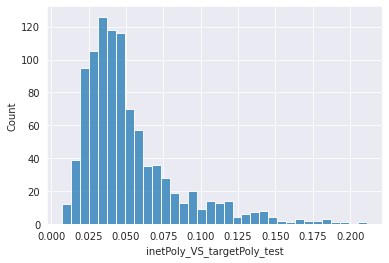

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

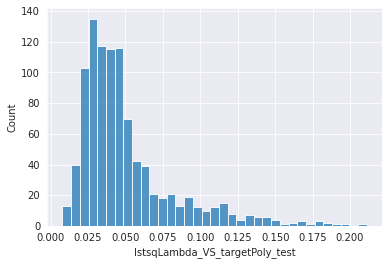

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

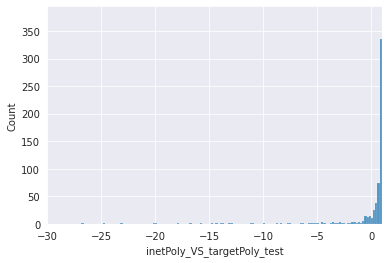

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

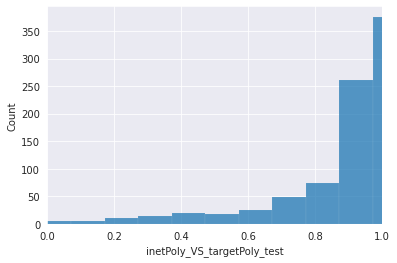

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

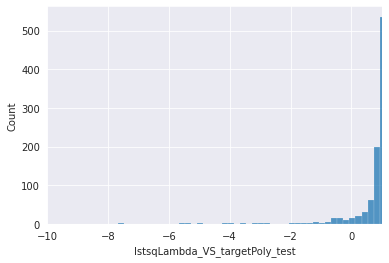

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

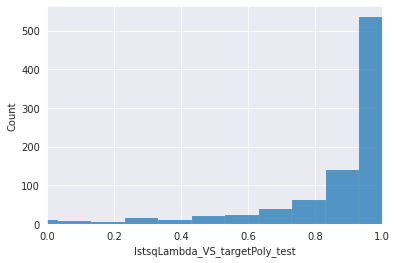

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.0055*a**1.0 - 0.5873*a**2.0 - 0.937*a**3.0 - 0.067*a**4.0 + 0.4853*a**5.0 + 0.5663

LSTSQ Target Poly:


0.4911*a**1.0 - 0.6617*a**2.0 - 7.4502*a**3.0 + 11.6806*a**4.0 - 5.1188*a**5.0 + 0.5271

LSTSQ Lambda Poly:


0.4911*a**1.0 - 0.6617*a**2.0 - 7.4502*a**3.0 + 11.6806*a**4.0 - 5.1188*a**5.0 + 0.5271

I-Net Poly:


0.857599973678589*a**1.0 - 3.39269995689392*a**2.0 + 0.246999993920326*a**3.0 + 2.56839990615845*a**4.0 - 1.31449997425079*a**5.0 + 0.509700000286102

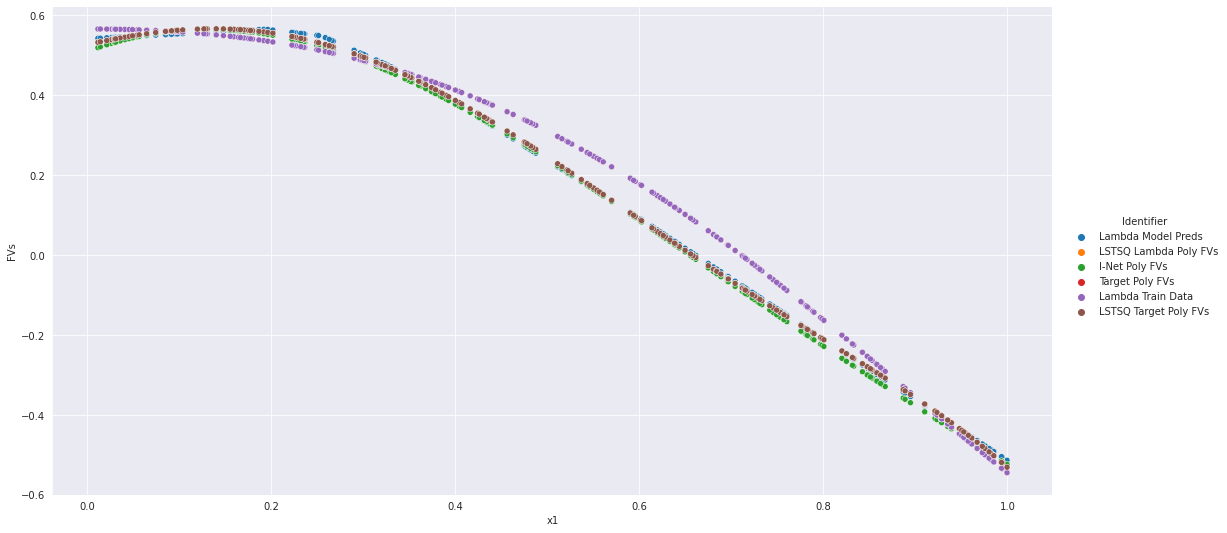

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.005345364031438299 | 0.9996804213333292 |   -    |  0.4911*a**1.0 - 0.6617*a**2.0 - 7.4502*a**3.0 +   |
|            vs.            |                      |                    |        |      11.6806*a**4.0 - 5.1188*a**5.0 + 0.5271       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.0108152133077580

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

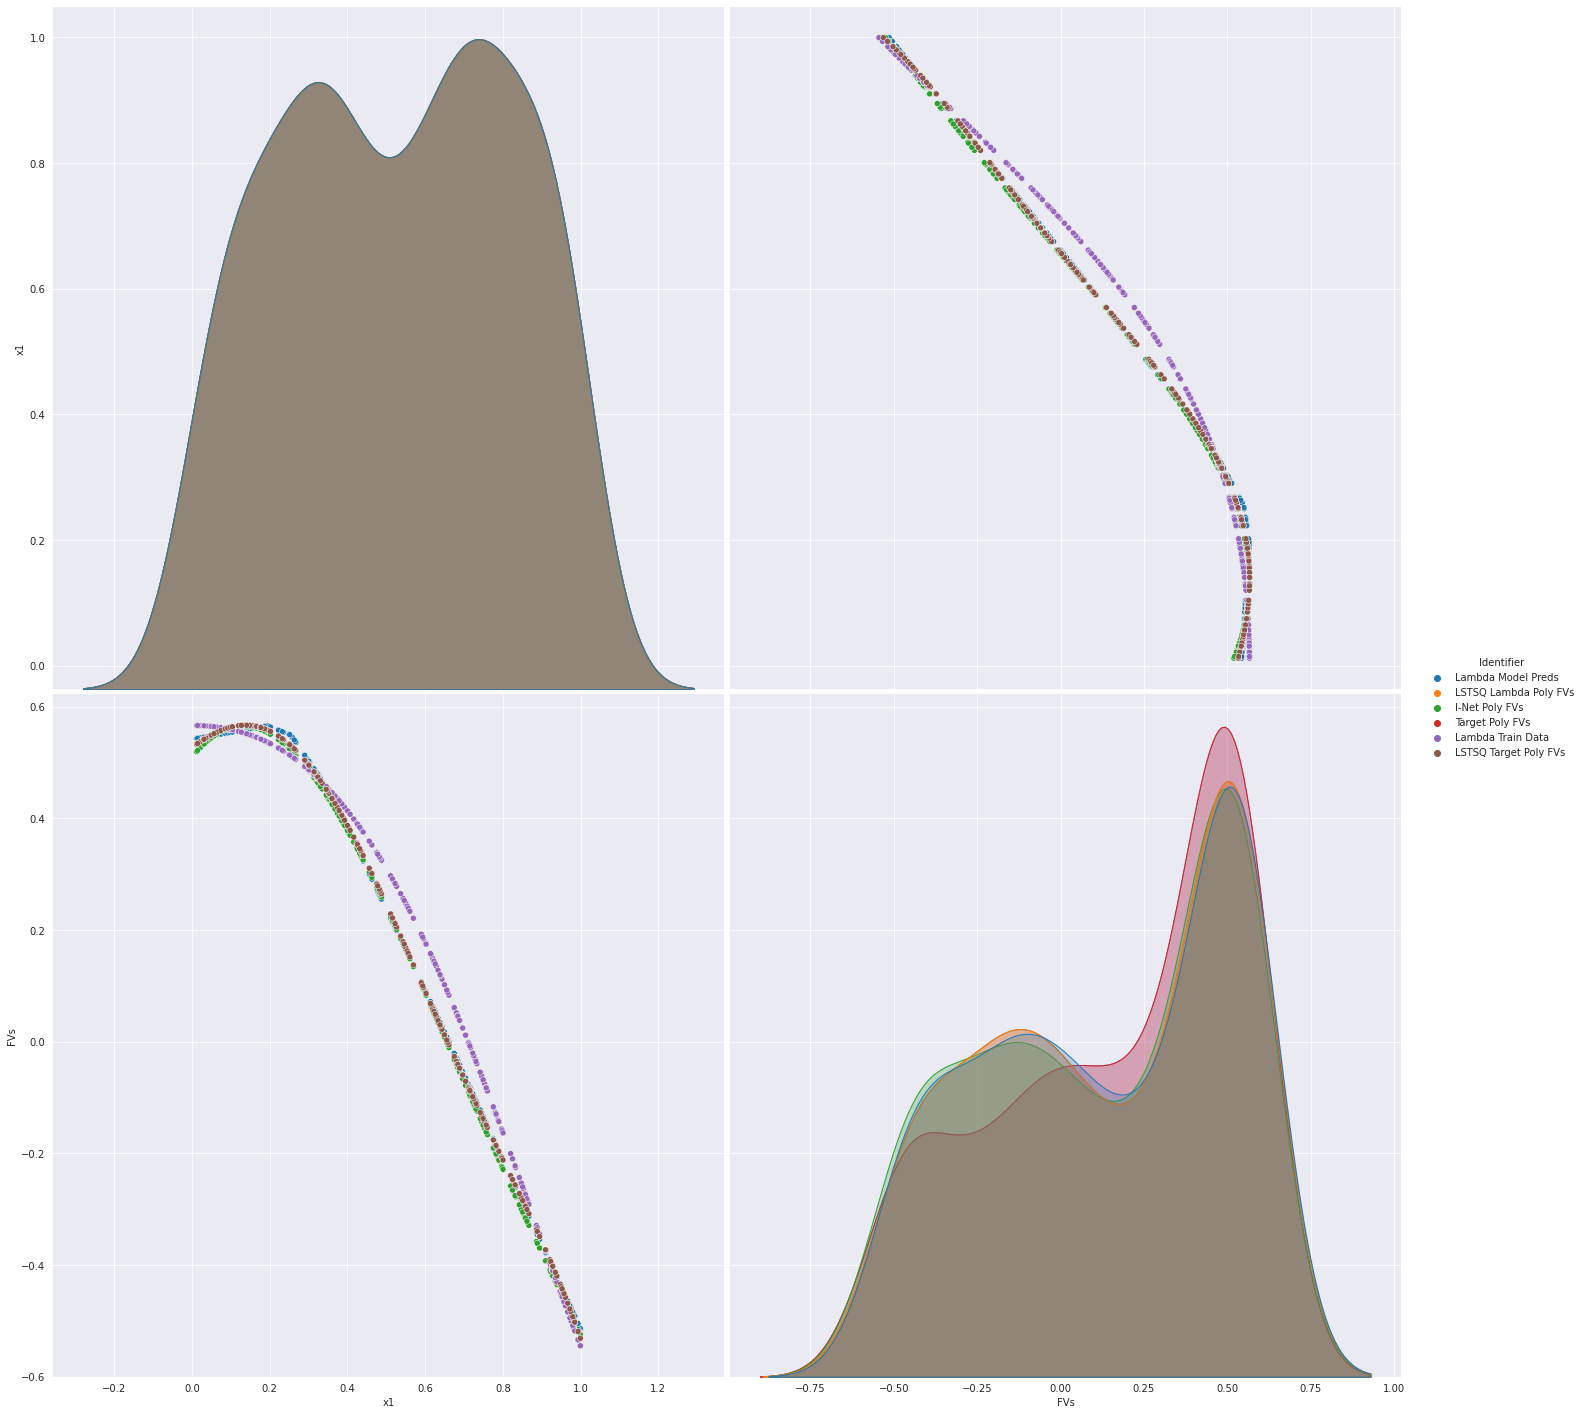

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.005345364031438299 | 0.9996804213333292 |   -    |  0.4911*a**1.0 - 0.6617*a**2.0 - 7.4502*a**3.0 +   |
|            vs.            |                      |                    |        |      11.6806*a**4.0 - 5.1188*a**5.0 + 0.5271       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.0108152133077580

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

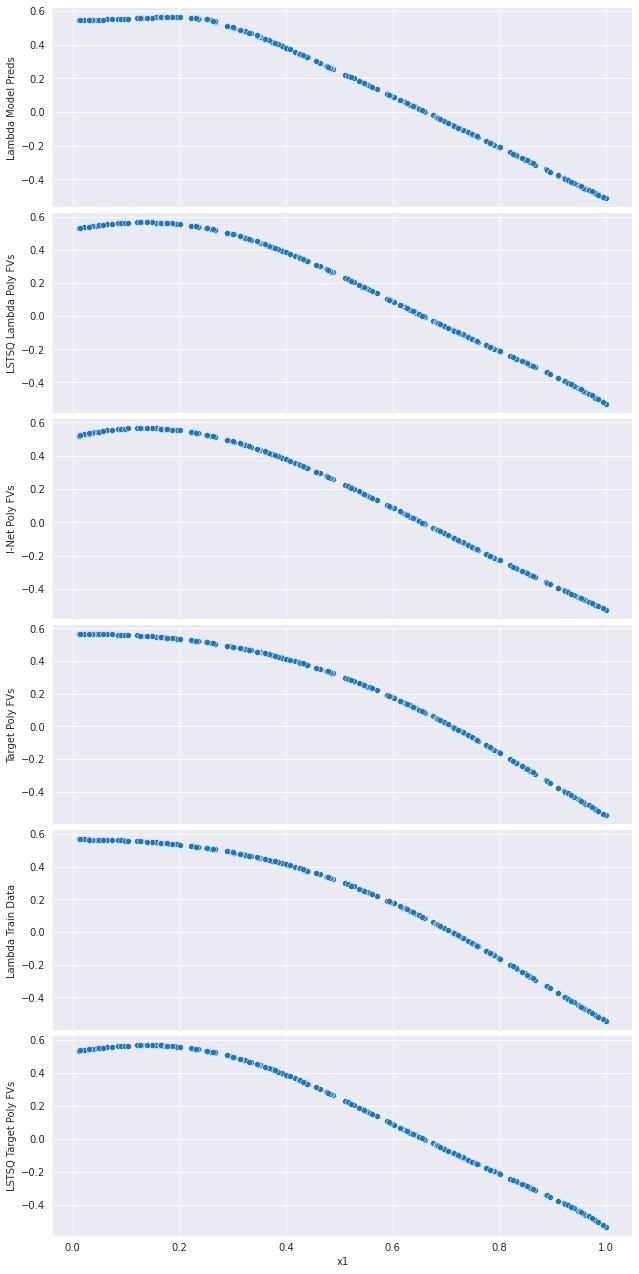

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.005345364031438299 | 0.9996804213333292 |   -    |  0.4911*a**1.0 - 0.6617*a**2.0 - 7.4502*a**3.0 +   |
|            vs.            |                      |                    |        |      11.6806*a**4.0 - 5.1188*a**5.0 + 0.5271       |
|  LSTSQ Lambda Preds Poly  |                      |                    |        |                                                    |
|                           |                      |                    |        |                                                    |
|       Lambda Preds        | 0.0108152133077580

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0418


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3303


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6153


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()